In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, SimpleRNN
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 30
test_date = 304

level_1 = 30
level_2 = 80
level_3 = 150

num_level = 4

pm_target = level_3 * 2
wind_speed_target = 14 # 강한 바람
wind_direction_target = 360 # 16방위

year = 365
train_cut = year * 9 + 1 -30

test_cut = -test_date

In [3]:
### 데이터 로드

data = pd.read_csv('dataset/PM_2.5_dataset_09_19.csv', index_col=0)
data.head()

,PM Seoul,PM Beijing,avg temprature,avg humidity,avg wind speed seoul,max wind direction seoul,avg wind speed back,max wind direction back
date,,,,,,,,
2009-01-01,43.739130,181.083875,-5.8,45.8,2.3,290.0,4.5,320
2009-01-02,45.750000,168.780998,-2.8,51.5,1.6,290.0,4.2,320
2009-01-03,46.833333,177.560185,-1.0,48.3,1.8,20.0,2.8,320
2009-01-04,40.083333,169.828704,0.4,44.3,1.9,290.0,3.1,290
2009-01-05,58.541667,140.598765,-1.6,53.1,2.2,290.0,5.0,290


In [4]:
pm_seoul_data = data['PM Seoul'].values
pm_beijing_data = data['PM Beijing'].values
wind_speed_seoul_data = data['avg wind speed seoul'].values
wind_direction_seoul_data = data['max wind direction seoul'].values
wind_speed_back_data = data['avg wind speed back'].values
wind_direction_back_data = data['max wind direction back'].values

In [5]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return temp_data

In [6]:
def pm_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / pm_target)
        
    return norm_data

In [7]:
norm_pm_seoul = np.array(make_sequential(pm_norm_window(pm_seoul_data)))

In [ ]:
## k-fold 교차검증

k = 9

num_val_samples = len(norm_pm_seoul) // k

all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = norm_pm_seoul

In [8]:
norm_result = norm_pm_seoul  
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3256, 30, 1) (366, 30, 1) (304, 30, 1)
(3256, 1) (366, 1) (304, 1)


In [ ]:
MODEL_SAVE_FOLBER_PATH = './model/checkpoint/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [ ]:
# 모델 불러오기
model = load_model('model/pm_prediction_Single RNN with a single factor.h5')

In [9]:
model = Sequential()

for i in range (2):
    model.add(LSTM(32, return_sequences=True, input_shape=(seq_len, 1), dropout=0.2, recurrent_dropout=0.2))   


model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.summary()

W1119 15:50:13.528440 24456 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1119 15:50:13.778369 24456 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1119 15:50:13.833352 24456 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1119 15:50:14.101266 24456 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1119 15:50:14.109264 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 37,569
Trainable params: 37,569
Non-trainable params: 0
_________________________________________________________________


In [10]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='mse', optimizer='adam')

hist=model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=100, epochs=50)

W1119 15:51:13.407313 24456 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1119 15:51:13.784205 24456 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1119 15:51:15.239727 24456 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3256 samples, validate on 366 samples
Epoch 1/50
3256/3256 [==============================] - 18s 6ms/step - loss: 0.0121 - val_loss: 0.0047
Epoch 2/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0092 - val_loss: 0.0048
Epoch 3/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0092 - val_loss: 0.0045
Epoch 4/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 5/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0092 - val_loss: 0.0046
Epoch 6/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 7/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0092 - val_loss: 0.0048
Epoch 8/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 9/50
3256/3256 [==============================] - 5s 1ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 10/50
3256/3256 [===========

In [17]:
from keras.models import load_model

# 모델 저장

model. save('model/pm_prediction_Single RNN with a single factor 2.h5')


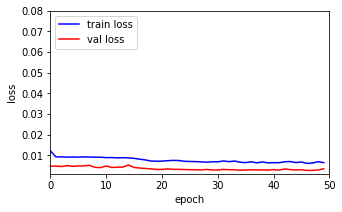

In [11]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.xlim([0, 50])
plt.ylim([0.001, 0.01])

plt.show()

In [12]:
## 결과 실제화
y_true = pm_seoul_data[test_cut:]

pred = model.predict(x_test)

y_pred = pred * pm_target

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


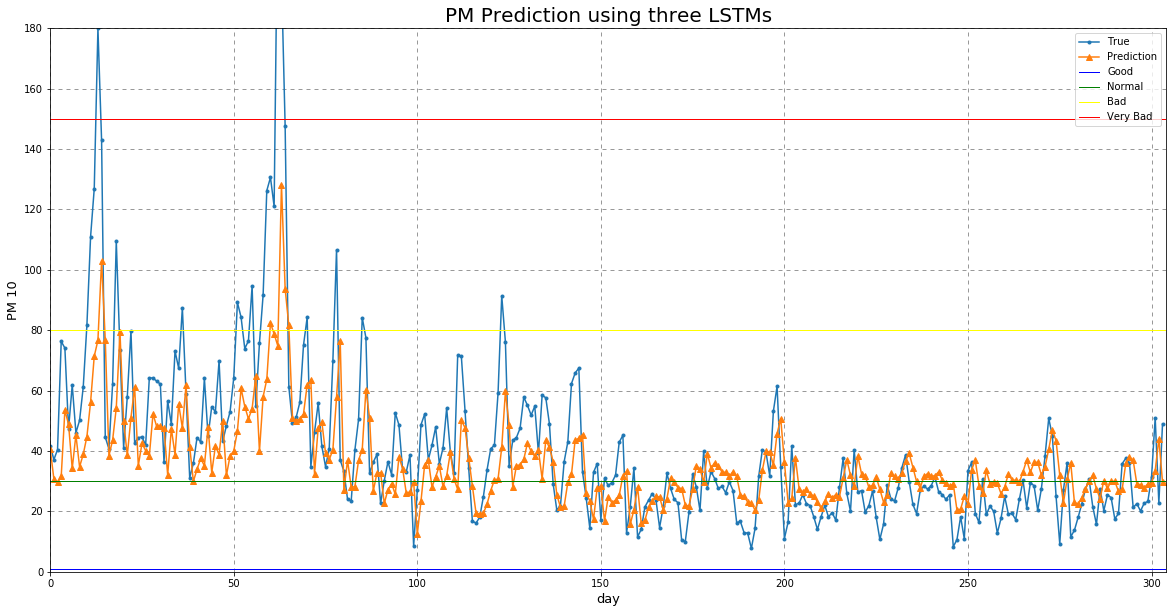

In [17]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction using three LSTMs', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=level_1, color='green', linewidth=1, label='Normal')
plt.axhline(y=level_2, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=level_3, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 10', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 180])

ax.legend()
plt.show()

In [14]:
def pm_level(pm):

    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif level_1 < pm[i] <= level_2:
            level_temp.append(2)
        elif level_2 < pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [15]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [16]:
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Veray Bad' accuracy:", level_acc[3])

total accuracy: 0.6513157894736842
level 'Good' accuracy: 0.6153846153846154
level 'Normal' accuracy: 0.7516339869281046
level 'Bad' accuracy: 0.16666666666666666
level 'Veray Bad' accuracy: 0.0
